# Introduction
This notebook is for testing the validity of our algorithm to model an semi-flexible rod-pin filaments.

Filaments are composed of inextensible rods (spherocylinders with length-width aspect ratios larger than 2) attached in series by a pinning constraint, i.e., the minus-end of the next rod is constrained to be at the position of the plus-end of the previous.

### Imports
Import libraries and write settings here.

In [23]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv, erfi
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import physical_scales as ps

# Graph style settings
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
# silence warnings
import warnings
warnings.filterwarnings("ignore")

torch device: cuda


## Deterministic tests

The simplest tests we can run are those of a kinked 2-rod filament with bending rigidity and track how this object relaxes. There are analytic solutions to this 

## Brownian semi-flexible rod dimer

### Pure angle potential
We would like to test the distribution of angles between line segments 0-1 and 1-2. We would also like to study the distribution of segment lengths of the trimer. We will choose parameters so that the trimers angle distribution has a standard deviation of $\pi/16$ and the segment lengths of 20\% of the average bond length.

The angle distribution is given by the following equation:
$$ P(\theta) = \frac{\sin(\theta)\exp\left(-\frac{\beta\kappa_B\theta^2}{2}\right)}{Z}$$
with the partition function given by
$$Z = \int_0^\pi d\theta \sin(\theta)\exp\left(-\frac{\beta\kappa_B\theta^2}{2}\right)= \frac{1}{2} e^{-\frac{1}{2 \beta  \kappa _B}} \sqrt{\frac{\pi}{2\beta  \kappa _B}} \left(2 \text{erfi}\left(\frac{1}{
   \sqrt{2\beta  \kappa _B}}\right)-\text{erfi}\left(\frac{1-i \pi  \beta  \kappa _B}{ \sqrt{2\beta  \kappa _B}}\right)-\text{erfi}\left(\frac{1+i
   \pi  \beta  \kappa _B}{\sqrt{2 \beta  \kappa _B}}\right)\right)$$
with $\kappa_B$ being the bending rigidity of the chain and $\beta=1/k_BT$. Note: the full probability distribution comes from integrating the Boltzmann factor of the total energy 
$$e^{-\beta U({\bf r}_1,{\bf r}_2)} \quad \text{where} \quad U({\bf r}_1,{\bf r}_2) = \frac{\kappa_B}{2}(\cos^{-1}(\hat{r}_1\cdot\hat{r}_2))^2,$$
over all space, but the radial contribution cancels out with the same term in the partition function when you marginalize radial extension. 

### Cosine potential
Typically bending constraints in inextensible rod filaments use a potential
$$e^{-\beta U({\bf r}_1,{\bf r}_2)} \quad \text{where} \quad U({\bf r}_1,{\bf r}_2) = \frac{\kappa_B}{2}(1-\hat{r}_1\cdot\hat{r}_2)^2,$$
<!-- The average angle is given by 
$$\langle\theta\rangle=\frac{\sqrt{\frac{2}{\pi }} \left(1-\exp\left(-\frac{\pi^2}{2\sigma_\theta^2}\right)\right)}{\sigma_\theta \text{erf}\left(\frac{\pi }{\sqrt{2}\sigma_\theta}\right)}$$  -->


The standard deviation is given by $\sigma_\theta=\sqrt{\frac{1}{\beta\kappa_B}}$. Since the inverse temperature is $\beta = 1/.0041$ pN $\mu\text{m}$ we can choose $\kappa_B = \frac{1}{\beta\sigma_\theta^2} = \frac{.0041}{\left(\frac{\pi}{16}\right)^2}$

In [59]:
kappa = .0041/(np.power(np.pi/16., 2))
kappa

0.10634671435099774

### Data

In [ ]:
data_dir = Path.home() / "projects/DATA/Testing/"
data_dir_list = [
    data_dir / "SemiFlexRodDimer",
]
for i in data_dir_list:
    assert i.exists(), f"{i} does not exist"


I will leave the spring stiffness at $k=3650$ pN/$\mu\text{m}$ though we should see how changing this affects the results.

### Run parameters
```yaml
viscosity : 1 # pN s/um^2
dt : 0.00001 s 
T_tot : 1 s  
t_snap : 0.001 s 
bendLinkKappa: [.106, .106, .106] # pN/rad
KBT: 0.00411 # controls Brownian motion of MT
```

### Results

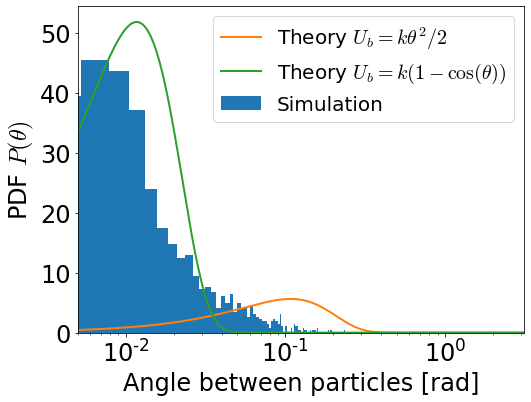

In [21]:
theta_arr = np.logspace(-4, np.log10(np.pi), 1000)
kappa = 30
sigma2 = .00411/kappa
sigma = np.sqrt(sigma2)
partition_func1 = .5 * np.exp(-0.5*sigma)*np.sqrt(.5*np.pi*sigma)*( 2* erfi(np.sqrt(sigma*.5))
                                                                   -erfi((1.j*np.pi+sigma)/np.sqrt(sigma*.5))
                                                                   -erfi((-1.j*np.pi+sigma)/np.sqrt(sigma*.5)))
prob_func1 = np.sin(theta_arr)*np.exp(-np.power(theta_arr,2)/(2.*sigma))/partition_func1
partition_func2 = (1-np.exp(-2/(sigma2)))*(sigma2)
prob_func2 = np.sin(theta_arr)*np.exp((np.cos(theta_arr)-1.)/(sigma2))/partition_func2

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# timestep = 0.0001
# timesnap = 0.001
# Total time = 10
with h5py.File(next(data_dir_list[0].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dir_arr = sy_dat[:, 5:8, :] - sy_dat[:, 2:5, :]
    rod_length = np.linalg.norm(dir_arr[0,:,0])
    dot_arr = np.einsum('ij,ij->j', dir_arr[0], dir_arr[1])/(rod_length**2)
    angle_arr = np.arccos(dot_arr)
    _ = axarr.hist(angle_arr, bins=100, density=True, label='Simulation')
    _ = axarr.plot(theta_arr, prob_func1, label='Theory $U_b = k\\theta^2/2$')
    _ = axarr.plot(theta_arr, prob_func2, label='Theory $U_b = k(1-\cos(\\theta))$')
    _ = axarr.legend()
    _ = axarr.set_xlabel('Angle between particles [rad]')
    _ = axarr.set_ylabel('PDF $P(\\theta)$')
    _ = axarr.set_xlim(.005, np.pi)
    _ = axarr.set_xscale('log')
    # print(dist_arr.mean())

# Larger tests and scan of parameters

We should test the two spring stiffnesses together to make sure there is no unexpected growth of errors between them. We will measure these as the standard deviation of the angle distribution and the standard deviation of the distance between beads. For bending rigidity we will us angle deviations of $\sigma_b=\{\pi/2, \pi/16, \pi/64\}$ and for spring stiffness $\kappa = k_bT/\sigma^2$ where $\sigma=\{b, b/10, b/100\}$.

In [24]:
kBT = .00411
kappa_bend = kBT/(np.power(np.array([np.pi/2, np.pi/16.,np.pi/64]), 2))
kappa_bend 

array([1.66572026e-03, 1.06606097e-01, 1.70569755e+00])

We will also us 1000 trimers with 1000 time snapshots with $t_{snap}=.001$ for a total time of 1 second different time steps $dt = \{10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}\}$ s. Just to make sure that we achieve relaxation during these times.

In [24]:
# gamma = ps.get_drag_coeff(.02, 1)
# tau = gamma/kappa_ext 
# tau

In [3]:
theta_arr = np.linspace(0, np.pi, 1000)
def get_theta_potential_theory(theta_arr, kappa):
    sigma2 = .00411/(kappa)
    partition_func = .5 * np.exp(-0.5*sigma2)*np.sqrt(.5*np.pi*sigma2)*( 2* erfi(np.sqrt(sigma2*.5))
                                                                   -erfi((1.j*np.pi+sigma2)/np.sqrt(sigma2*.5))
                                                                   -erfi((-1.j*np.pi+sigma2)/np.sqrt(sigma2*.5)))
    prob_func = np.sin(theta_arr)*np.exp(-np.power(theta_arr,2)/(2.*sigma2))/partition_func
    return prob_func

def get_extend_potential_theory(x_arr, kappa, b):
    sigma2 = .00411/kappa
    # partition_func = np.sqrt(np.pi*np.power(sigma2,3)/2.) 
    prob_func = np.power(x_arr, 2)*np.exp(-np.power(x_arr-b,2)/(2.*sigma2))
    partition_func = np.sum(prob_func)*(x_arr[1]-x_arr[0])
    prob_func = prob_func/partition_func
    return prob_func

def get_cosine_potential_theory(theta_arr,kappa):
    a = kappa/.00411
    partition_func = (1-np.exp(-2*a))/a
    prob_func = np.sin(theta_arr)*np.exp((np.cos(theta_arr)-1.)*a)/partition_func
    return prob_func




In [44]:
test_dir = Path.home() / "projects/DATA/Testing/SemiFlexRodDimer"
h5_list = list(test_dir.glob('simulations/*/analysis/raw*.h5'))
data_dict = {}
for h5d in h5_list:
    with h5py.File(h5d, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['bendLinkKappa']
        dt = run_params['dt']
        # See if dt value is already in data_dict. If not add it otherwise append to existing list
        if kappa_bend not in data_dict:
            data_dict[kappa_bend] = {}
        data_dict[kappa_bend][dt]= h5d

# pprint(data_dict)
k_bend_list = sorted(data_dict.keys())
print("k_bend: ", k_bend_list)
dt_list = sorted(data_dict[k_bend_list[0]].keys(), reverse=True)
print("dt: ", dt_list)

k_bend:  [0.00166572026, 0.106606097, 1.70569755]
dt:  [0.001, 0.0001, 1e-05, 1e-06]


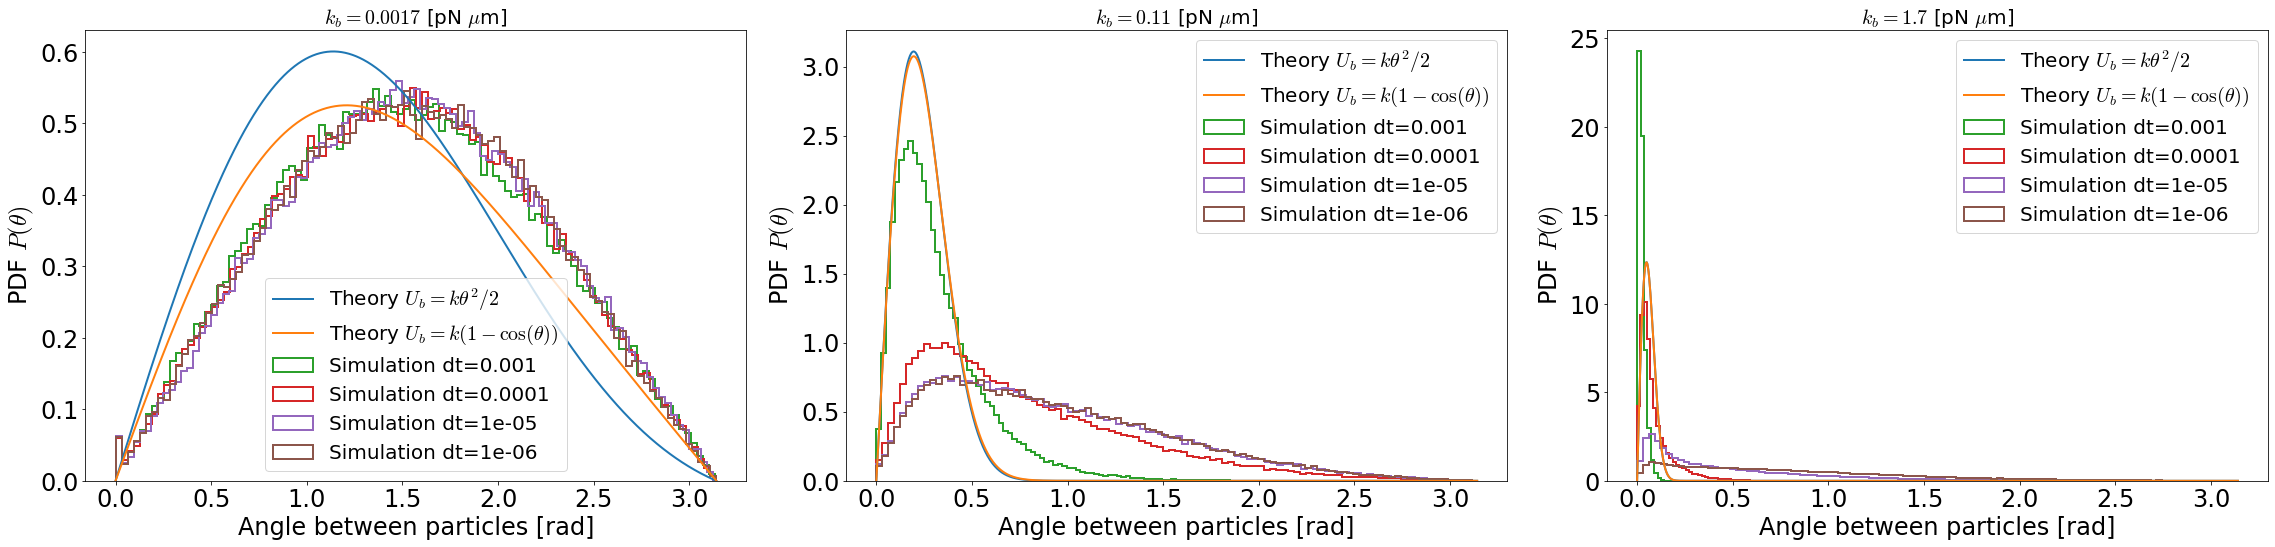

In [45]:
fig, axarr = plt.subplots(1,3, figsize=(32, 8))
theta_arr = np.linspace(0, np.pi, 1000)
for i, k_bend in enumerate(k_bend_list):
    _ = axarr[i].plot(theta_arr, get_theta_potential_theory(theta_arr, k_bend), label='Theory $U_b = k\\theta^2/2$')
    _ = axarr[i].plot(theta_arr, get_cosine_potential_theory(theta_arr, k_bend), label='Theory $U_b = k(1-\cos(\\theta))$')
    for k, dt in enumerate(dt_list):
        try: 
            with h5py.File(data_dict[k_bend][dt], 'r') as h5_data:
                run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
                kappa_bend = run_params['bendLinkKappa']
                time_arr = h5_data['time'][:] 
                # Load in sylinder data
                try:
                    sy_dat = h5_data['raw_data/sylinders'][...]
                except:
                    print(f'dt = {dt} not made.')
                    continue
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                dir_arr = sy_dat[:, 5:8, :] - sy_dat[:, 2:5, :]
                rod_length = np.linalg.norm(dir_arr[0,:,0])
                # Average over all the trimers
                angle_arr = []
                for n in range(0, com_arr.shape[0], 2):
                    dot_arr = np.einsum('ij,ij->j', dir_arr[n], dir_arr[n+1])/(rod_length**2)
                    angle_arr += (np.arccos(dot_arr).tolist())
                _ = axarr[i].hist(angle_arr, bins=100, density=True, label=f'Simulation dt={dt}', histtype='step', linewidth=2)
        except:
            pass
    _ = axarr[i].set_title(f'$k_b = {kappa_bend:.2g}$ [pN $\mu$m]')
    _ = axarr[i].set_xlabel('Angle between particles [rad]')
    _ = axarr[i].set_ylabel('PDF $P(\\theta)$')
    _ = axarr[i].legend()
# _ = plt.xlim(0, 1)
# _ = axarr[1,2].legend()
#         # print(dist_arr.mean())
fig.tight_layout()

k_bend:  [0.00166572026, 0.106606097, 1.70569755]
dt:  [0.001, 0.0001, 1e-05, 1e-06]


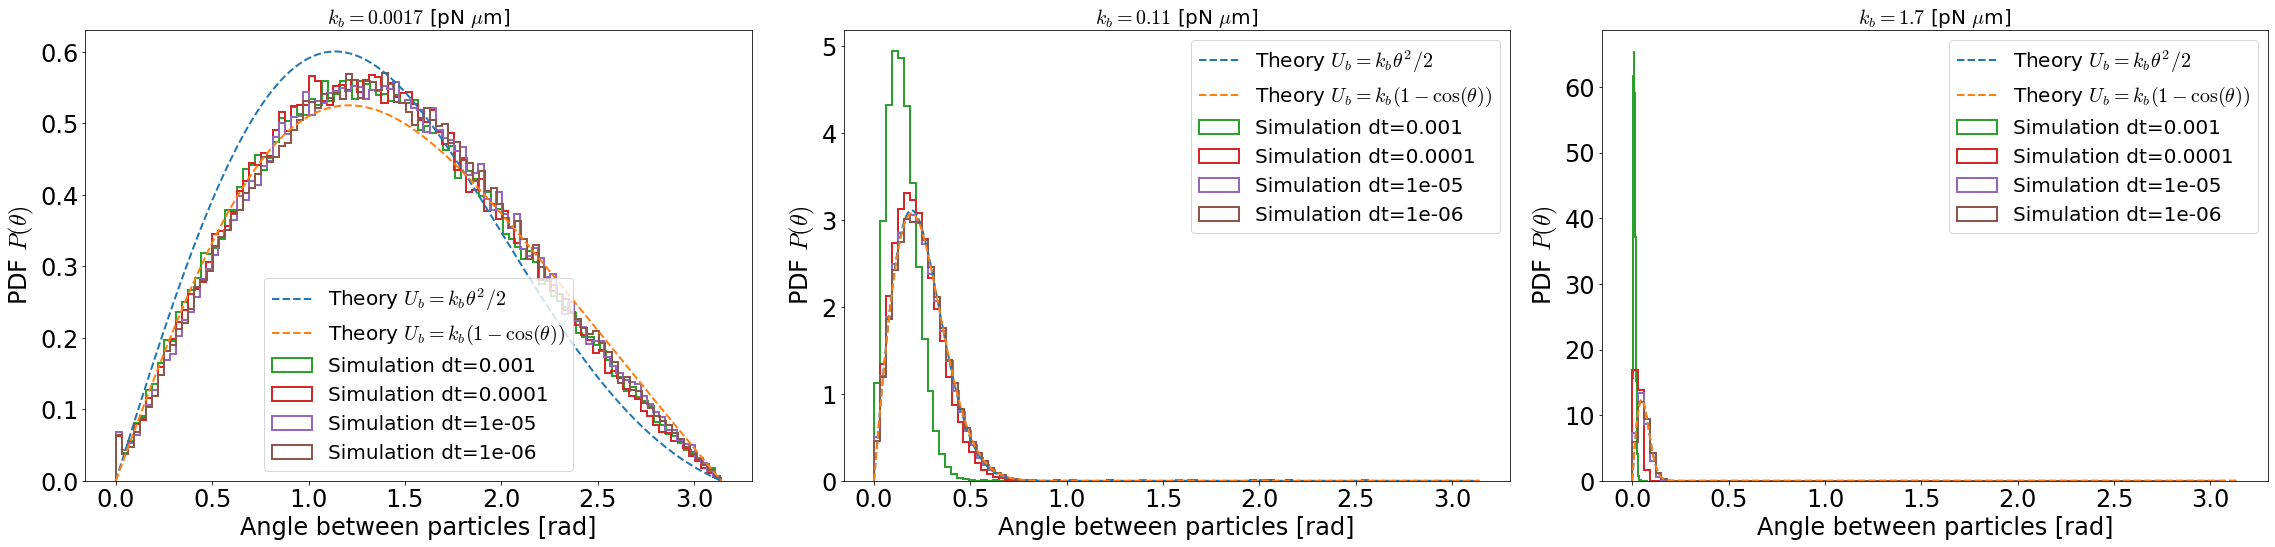

In [46]:
test_dir = Path.home() / "projects/DATA/Testing/SemiFlexRodDimer_v2"
h5_list = list(test_dir.glob('simulations/*/analysis/raw*.h5'))
data_dict = {}
for h5d in h5_list:
    with h5py.File(h5d, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['bendLinkKappa']
        dt = run_params['dt']
        # See if dt value is already in data_dict. If not add it otherwise append to existing list
        if kappa_bend not in data_dict:
            data_dict[kappa_bend] = {}
        data_dict[kappa_bend][dt]= h5d

# pprint(data_dict)
k_bend_list = sorted(data_dict.keys())
print("k_bend: ", k_bend_list)
dt_list = sorted(data_dict[k_bend_list[0]].keys(), reverse=True)
print("dt: ", dt_list)

fig, axarr = plt.subplots(1,3, figsize=(32, 8))
theta_arr = np.linspace(0, np.pi, 1000)
for i, k_bend in enumerate(k_bend_list):
    _ = axarr[i].plot(theta_arr, get_theta_potential_theory(theta_arr, k_bend), label='Theory $U_b = k_b\\theta^2/2$', linestyle='--')
    _ = axarr[i].plot(theta_arr, get_cosine_potential_theory(theta_arr, k_bend), label='Theory $U_b = k_b(1-\cos(\\theta))$', linestyle='--')
    for k, dt in enumerate(dt_list):
        try: 
            with h5py.File(data_dict[k_bend][dt], 'r') as h5_data:
                run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
                kappa_bend = run_params['bendLinkKappa']
                time_arr = h5_data['time'][:] 
                # Load in sylinder data
                try:
                    sy_dat = h5_data['raw_data/sylinders'][...]
                except:
                    print(f'dt = {dt} not made.')
                    continue
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                dir_arr = sy_dat[:, 5:8, :] - sy_dat[:, 2:5, :]
                rod_length = np.linalg.norm(dir_arr[0,:,0])
                # Average over all the trimers
                angle_arr = []
                for n in range(0, com_arr.shape[0], 2):
                    dot_arr = np.einsum('ij,ij->j', dir_arr[n], dir_arr[n+1])/(rod_length**2)
                    angle_arr += (np.arccos(dot_arr).tolist())
                _ = axarr[i].hist(angle_arr, bins=100, density=True, label=f'Simulation dt={dt}', histtype='step', linewidth=2)
        except:
            pass
    _ = axarr[i].set_title(f'$k_b = {kappa_bend:.2g}$ [pN $\mu$m]')
    _ = axarr[i].set_xlabel('Angle between particles [rad]')
    _ = axarr[i].set_ylabel('PDF $P(\\theta)$')
    # _ = axarr[i].set_yscale('log')
    _ = axarr[i].legend()
    # _ = axarr[i].set_ylim(0.001, 50)
    # _ = axarr[i].set_xlim(0.01, np.pi)
# _ = axarr[1,2].legend()
#         # print(dist_arr.mean())
fig.tight_layout()

## Long Brownian filament tests

0.06999987
[  1.00011451 177.67995269]


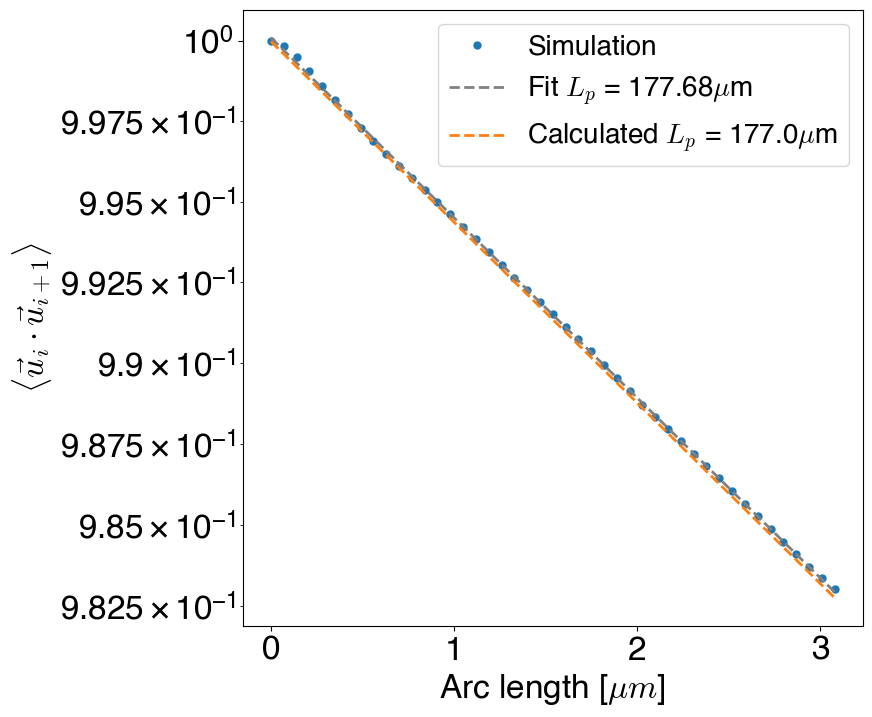

In [8]:
test_dir = Path.home() / 'projects/DATA/my_alens_data/PinRodSemiFlexTests/LongFilaments/PinRodSemiFlexFilament_v2'
fig, axarr = plt.subplots(1,1, figsize=(8, 8))

with h5py.File(next(test_dir.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    dir_arr = (-sy_dat[:, 2:5,100::10] + sy_dat[:, 5:8, 100::10])
    length = np.linalg.norm(dir_arr[0,:,0])
    print(length)
    dir_arr /= length
    n_segs = dir_arr.shape[0]-10
    dot_mat = np.einsum('ijk,ljk->ilk', dir_arr, dir_arr).mean(axis=2)
    arc_length_arr = np.arange(n_segs)*length
    avg_dot_arr = np.zeros(n_segs)
    avg_dot_arr[0] = 1.
    for i in range(1, n_segs):
        avg_dot_arr[i] = np.diag(dot_mat, i).mean()
    
    # Fit persistence length
    def fit_func(x, a, Lp):
        return a*np.exp(-x/Lp)
    
    popt, pcov = curve_fit(fit_func, arc_length_arr[:], avg_dot_arr[:])
    print(popt)
    kappa_bend = yaml.safe_load(h5_data.attrs['RunConfig'])['bendLinkKappa']
    kBT = .00411
    Lp = kappa_bend*length/kBT

    _ = axarr.plot(arc_length_arr[:], avg_dot_arr[:], marker='o', linestyle='none', markersize=5, label=f'Simulation')
    _ = axarr.plot(arc_length_arr, fit_func(arc_length_arr, *popt), color='gray',  linestyle='--', label='Fit $L_p$ = {:.2f}$\mu$m'.format(popt[1]))
    _ = axarr.plot(arc_length_arr, fit_func(arc_length_arr, 1, Lp), color='tab:orange',  linestyle='--', label=f'Calculated $L_p$ = {Lp:.1f}$\mu$m')
    # _ = axarr.set_ylim(.0001, 2)
    _ = axarr.legend()
    _ = axarr.set_yscale('log')
    _ = axarr.set_xlabel('Arc length [$\mu m$]')
    _ = axarr.set_ylabel('$\langle \\vec{u}_i \\cdot \\vec{u}_{i+1} \\rangle$')

## Long filament slice

In [48]:
test_dir = Path.home() / "projects/DATA/Testing/SemiFlexFilament"
h5_list = list(test_dir.glob('simulations/*/analysis/raw*.h5'))
data_dict = {}
for h5d in h5_list:
    with h5py.File(h5d, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['bendLinkKappa']
        seg_length = run_params['sylinderLength']
        dt = run_params['dt']
        # See if dt value is already in data_dict. If not add it otherwise append to existing list
        if kappa_bend not in data_dict:
            data_dict[kappa_bend] = {}
        if seg_length not in data_dict[kappa_bend]:
            data_dict[kappa_bend][seg_length] = {}
        data_dict[kappa_bend][seg_length][dt]= h5d

k_bend_list = sorted(data_dict.keys())
print("k_bend: ", k_bend_list)
seg_length_list = sorted(data_dict[k_bend_list[0]].keys())
print("seg_length: ", seg_length_list)
dt_list = sorted(data_dict[k_bend_list[0]][seg_length_list[-1]].keys(), reverse=True)
print("dt: ", dt_list)


k_bend:  [0.00166572026, 0.106606097, 1.70569755]
seg_length:  [0.01, 0.02, 0.05, 0.1, 0.2]
dt:  [0.001, 0.0001, 1e-05, 1e-06]


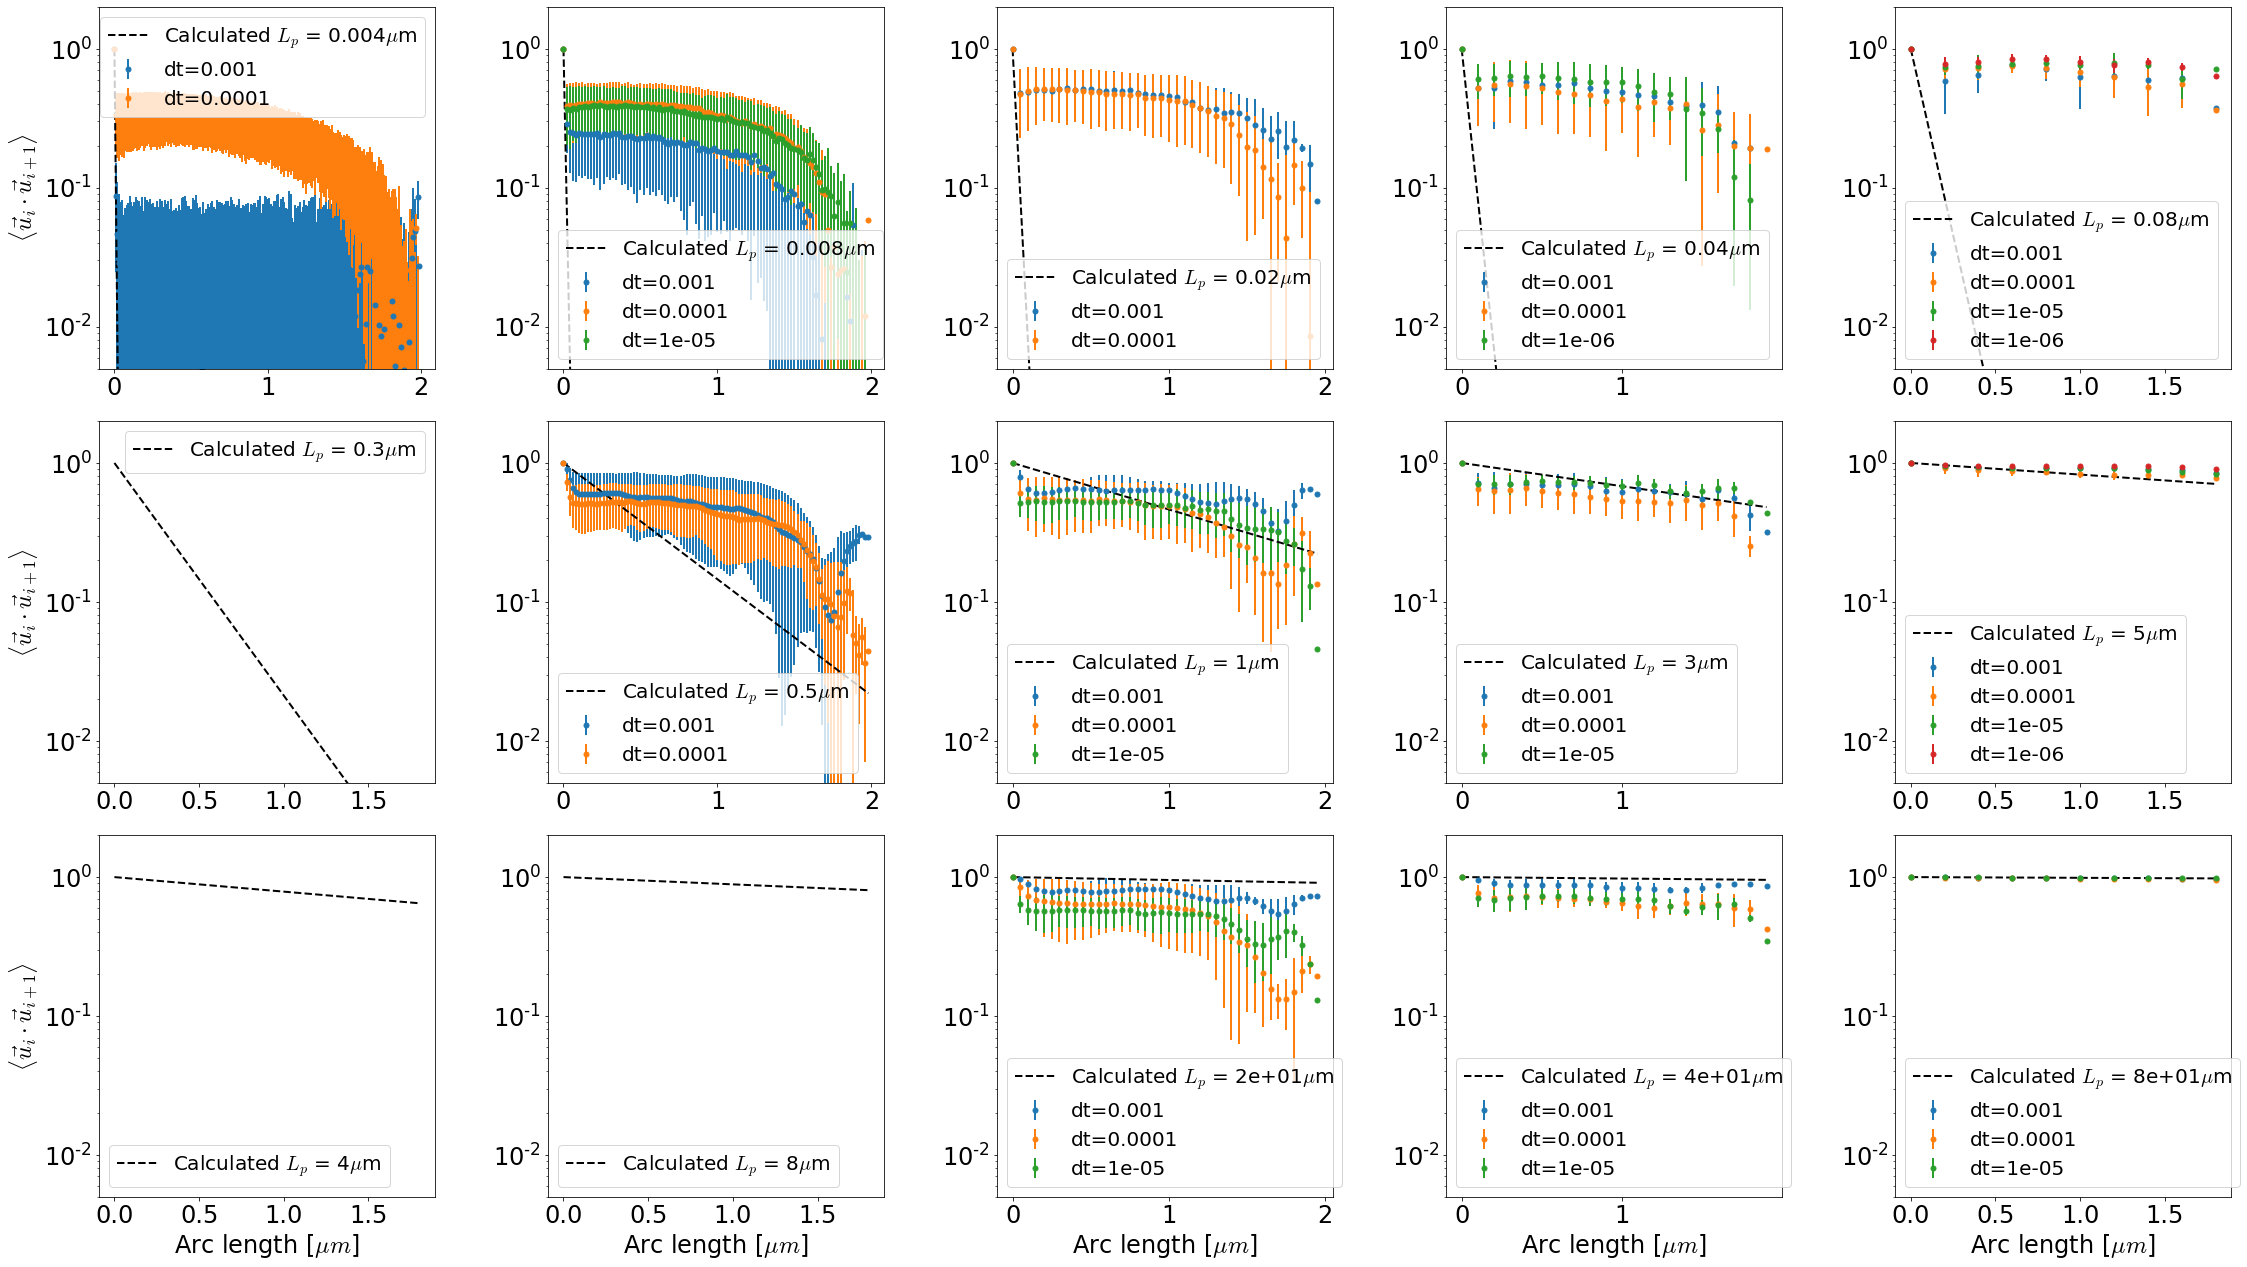

In [59]:
def fit_func(x, a, Lp):
    return a*np.exp(-x/Lp)
# TODO NEXT!!!
fig, axarr = plt.subplots(len(k_bend_list),len(seg_length_list), figsize=(32, 18))
theta_arr = np.linspace(0, np.pi, 1000)
for i, k_bend in enumerate(k_bend_list):
    for j, seg_length in enumerate(seg_length_list):
        Lp = k_bend*seg_length/kBT
        for k, dt in enumerate(dt_list):
            try: 
                with h5py.File(data_dict[k_bend][seg_length][dt], 'r') as h5_data:
                    run_params = yaml.safe_load(h5_data.attrs['RunConfig'])

                    time_arr = h5_data['time'][:] 
                    sy_dat = h5_data['raw_data/sylinders'][...]
                    dir_arr = (-sy_dat[:, 2:5,100::10] + sy_dat[:, 5:8, 100::10])
                    length = np.linalg.norm(dir_arr[0,:,0])
                    dir_arr /= length

                    n_segs = dir_arr.shape[0]
                    dot_mat = np.einsum('ijk,ljk->ilk', dir_arr, dir_arr).mean(axis=2)
                    arc_length_arr = np.arange(n_segs)*length
                    avg_dot_arr = np.zeros(n_segs)
                    std_dot_arr = np.zeros(n_segs)
                    avg_dot_arr[0] = 1.
                    std_dot_arr[0] = 0. 
                    for n in range(1, n_segs):
                        avg_dot_arr[n] = np.diag(dot_mat, n).mean()
                        std_dot_arr[n] = np.diag(dot_mat, n).std()
                _ = axarr[i,j].errorbar(arc_length_arr[:], avg_dot_arr[:], yerr=std_dot_arr, marker='o', linestyle='none', markersize=5, label=f'dt={dt}')
            except:
                pass

        _ = axarr[i,j].plot(arc_length_arr, fit_func(arc_length_arr, 1, Lp), color='black',  linestyle='--', label=f'Calculated $L_p$ = {Lp:.1g}$\mu$m')
        _ = axarr[i,j].set_yscale('log')
        # _ = axarr[i,j].set_xlabel('Arc length [$\mu m$]')
        # _ = axarr[i,j].set_ylabel('$\langle \\vec{u}_i \\cdot \\vec{u}_{i+1} \\rangle$')
        _ = axarr[i,j].legend()
        _ = axarr[i,j].set_ylim(.005, 2)
for ax in axarr[-1,:]:
    _ = ax.set_xlabel('Arc length [$\mu m$]')

for ax in axarr[:,0]:
    _ = ax.set_ylabel('$\langle \\vec{u}_i \\cdot \\vec{u}_{i+1} \\rangle$')
fig.tight_layout()